In [1]:
import itertools
import pulp
import matplotlib.pyplot as plt
from numpy import random
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from Data import load_data 
rng = random.default_rng(42)  # For reproducibility

In [2]:
#simulated data beed to replace with generalized dirichlet samples

players, profit1, profit2, weight = load_data("./nbasalariespoints.csv", "Player", "PS/G▼", "TOV", "SALARY")
capacity = 150_000_000
N = len(players)

In [3]:
# single-objective reference points
# 1. Maximize profit 1
model_p1 = pulp.LpProblem("max_profit1", pulp.LpMaximize)
x_p1 = pulp.LpVariable.dicts("x", range(N), cat="Binary")
model_p1 += pulp.lpSum(profit1[i]*x_p1[i] for i in range(N))
model_p1 += pulp.lpSum(weight[i]*x_p1[i] for i in range(N)) <= capacity
model_p1.solve(pulp.PULP_CBC_CMD(msg=0))
max_p1 = pulp.value(model_p1.objective)
choices_p1 = [i for i in range(N) if x_p1[i].value() > 0.5]
# 2. Maximize profit2
model_p2 = pulp.LpProblem("max_profit2", pulp.LpMaximize)
x_p2 = pulp.LpVariable.dicts("x", range(N), cat="Binary")
model_p2 += pulp.lpSum(profit2[i]*x_p2[i] for i in range(N))
model_p2 += pulp.lpSum(weight[i]*x_p2[i] for i in range(N)) <= capacity
model_p2.solve(pulp.PULP_CBC_CMD(msg=0))
max_p2 = pulp.value(model_p2.objective)

In [4]:

# ε-constraint baselibe.  for any value of profit 2 maxinimize profit 1
p1_val = []
p2_val = []

solutions = []

eps = 10
model = pulp.LpProblem(f"eps_{eps:.1f}", pulp.LpMaximize)
x = pulp.LpVariable.dicts("x", range(N), cat="Binary")
model += pulp.lpSum(profit1[i]*x[i] for i in range(N))
model += pulp.lpSum(profit2[i]*x[i] for i in range(N)) <= eps
model += pulp.lpSum(weight[i]*x[i] for i in range(N)) <= capacity
model += pulp.lpSum(x[i] for i in range(N)) <= 15 

model.solve(pulp.PULP_CBC_CMD(msg=0))
if model.status == 1:  # optimal
    p1_val.append(pulp.value(model.objective))
    p2_val.append(sum(profit2[i]*x[i].value() for i in range(N)))
    choices = [i for i in range(N) if x[i].value() > 0.5]
    solutions.append(choices)

Found 1 Pareto solutions:

 0: Profit1 = 160.2, Profit2 = 10.0, Weight = 97,058,687
 Items = [ 11  14  29  33  44 100 130 132 133 188 245 294 308 318 338]


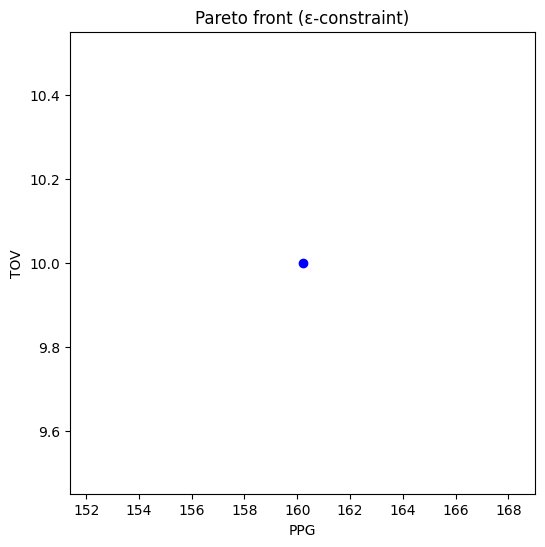

In [5]:
solutions = np.array(solutions);
unique_solutions, indices = np.unique(solutions, axis=0, return_index=True)
p1_val = np.array(p1_val)[indices]
p2_val = np.array(p2_val)[indices]

# Display results
print(f"Found {len(unique_solutions)} Pareto solutions:\n")
for idx,choices in enumerate(unique_solutions):
    print(f"{idx:2d}: Profit1 = {p1_val[idx]:.1f}, Profit2 = {p2_val[idx]:.1f}, Weight = {np.sum(weight[unique_solutions]):,}\n Items = {choices}")

# Plot objective space
plt.figure(figsize=(6,6))
plt.scatter(p1_val, p2_val, c='blue', marker='o', label='Pareto front')
plt.xlabel("PPG")
plt.ylabel("TOV")
plt.title("Pareto front (ε‑constraint)")
plt.show()


In [6]:
num_steps = 100

# ε-constraint loop: for different ε thresholds on profit2, maximize profit1

for eps in [max_p2 * i / num_steps for i in range(1, num_steps + 1)]:
    model = pulp.LpProblem(f"eps_{eps:.1f}", pulp.LpMaximize)
    x = pulp.LpVariable.dicts("x", range(N), cat="Binary")
    model += pulp.lpSum(profit1[i]*x[i] for i in range(N))
    model += pulp.lpSum(profit2[i]*x[i] for i in range(N)) >= eps
    model += pulp.lpSum(weight[i]*x[i] for i in range(N)) <= capacity
    model.solve(pulp.PULP_CBC_CMD(msg=0))
    if model.status == 1:  # optimal
        p1_val.append(pulp.value(model.objective))
        p2_val.append(sum(profit2[i]*x[i].value() for i in range(N)))
        choices = [i for i in range(N) if x[i].value() > 0.5]
        solutions.append(choices)



AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [ ]:
solutions = np.array(solutions);
unique_solutions, indices = np.unique(solutions, axis=0, return_index=True)
p1_val = np.array(p1_val)[indices]
p2_val = np.array(p2_val)[indices]



In [ ]:

# Display results
print(f"Found {len(unique_solutions)} Pareto solutions:\n")
for idx,choices in enumerate(unique_solutions):
    print(f"{idx:2d}: Profit1 = {p1_val[idx]:.1f}, Profit2 = {p2_val[idx]:.1f}, Items = {choices}")

# Plot objective space
plt.figure(figsize=(6,6))
plt.scatter(p1_val, p2_val, c='blue', marker='o', label='Pareto front')
plt.xlabel("Profit1")
plt.ylabel("Profit2")
plt.title("Pareto front (ε‑constraint)")
plt.show()
